In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils as ut

### Loading data
For the moment, every profile is stored in a ``pickle`` format. Let's see what the data looks like.

In [2]:
help(ut.load_data)

Help on function load_data in module utils:

load_data()
    Load data from pickle files in the 'profiles' directory.
    
    Returns:
        out_flattened (dict): Flattened dictionary containing all profiles.
        out_sorted (dict): Dictionary containing profiles sorted by file.



file profiles\profil_20190212.pkl contains 29 profiles, average length is 2265.83, std is 647.52
file profiles\profil_20190327.pkl contains 1 profiles, average length is 2832.00, std is 0.00
file profiles\profil_20200210.pkl contains 37 profiles, average length is 2866.70, std is 403.25
file profiles\profil_20200229.pkl contains 40 profiles, average length is 2317.03, std is 572.10
file profiles\profil_20200301.pkl contains 34 profiles, average length is 2098.74, std is 319.74
file profiles\profil_20220119.pkl contains 53 profiles, average length is 2436.04, std is 34.11
file profiles\profil_20220124.pkl contains 54 profiles, average length is 2416.70, std is 34.97
file profiles\profil_20220127.pkl contains 63 profiles, average length is 2139.13, std is 293.77
file profiles\profil_20220225.pkl contains 50 profiles, average length is 2445.74, std is 669.22


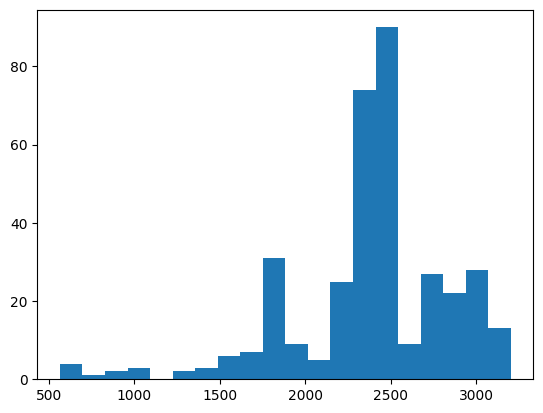

In [3]:
profiles_flattened, surveys = ut.load_data()

for survey, profiles in surveys.items():
    lengths = []
    for profile in profiles.values():
        lengths.append(len(profile))

    print(f'file {survey} contains {len(profiles)} profiles, average length is {np.mean(lengths):.2f}, std is {np.std(lengths):.2f}')

lengths = []
for profile in profiles_flattened.values():
    lengths.append(len(profile))
    
_ = plt.hist(lengths, 20)

Each file contains a dictionary where each key refers to a SMP profile from a given survey. Every profile is a dataframe with as many rows as there are depths observation, and columns give information on the properties of the snow.

In [4]:
profile = profiles_flattened['SMP_1399']
profile.columns

Index(['distance', 'force_median', 'fmax', 'L2012_lambda', 'L2012_f0',
       'L2012_delta', 'L2012_L', 'npeaks', 'B2009_psi', 'gradient_psi',
       'delta_bellaire', 'delta_bellairef5', 'layer'],
      dtype='object')

Plotting one profile shows us where the weak layer is with respect to some other parameters:

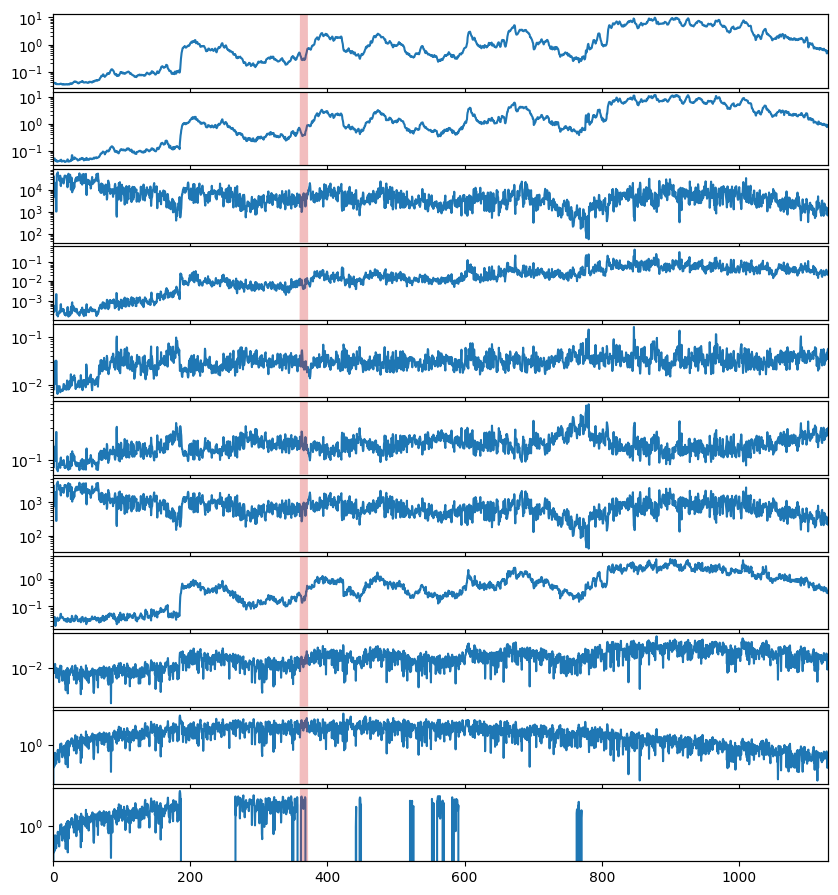

In [5]:
%matplotlib inline

features = profile.columns[1:-1]

fig, axs = plt.subplots(len(features), sharex='all', figsize=(10, len(features)))

for i, feature in enumerate(features):
    axs[i].plot(profile['distance'], np.abs(profile[feature]))

    axs[i].set_yscale('log')

    ax2 = axs[i].twinx()
    ax2.fill_between(profile['distance'], profile['layer'] == 'WL', 0,
    zorder=0, fc='tab:red', alpha=0.3)
    ax2.set_ylim(0, 1)
    ax2.set_yticks([])

axs[-1].set_xlim(0, profile['distance'].iloc[-1])
fig.subplots_adjust(hspace=0.05)

How different are every surveys? We can look at every profile from a given survey by plotting one of their features with respect to the weak layer location. 

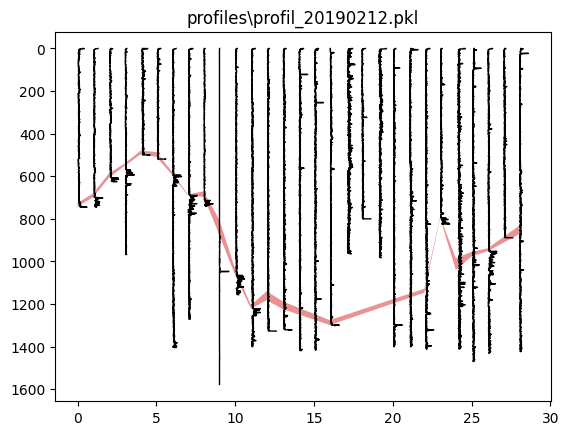

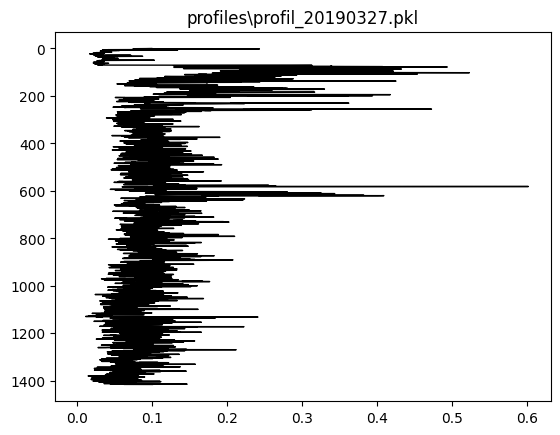

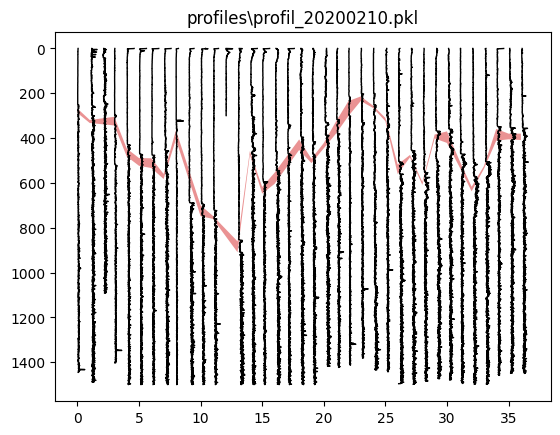

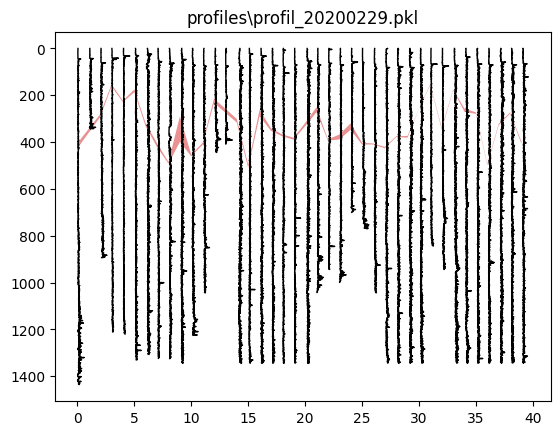

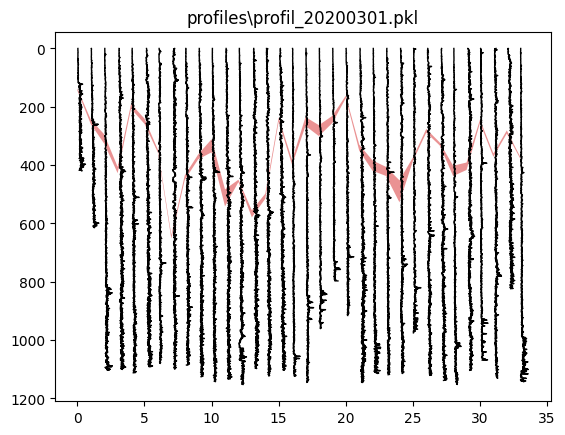

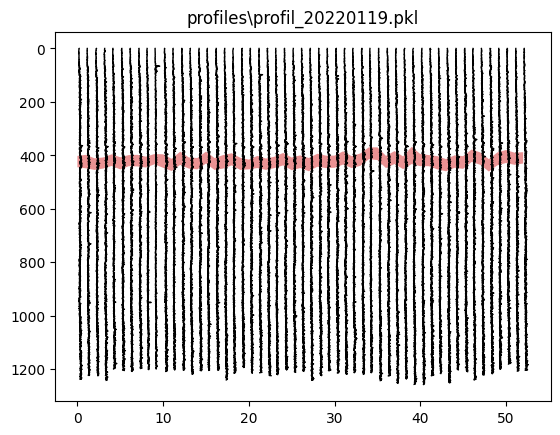

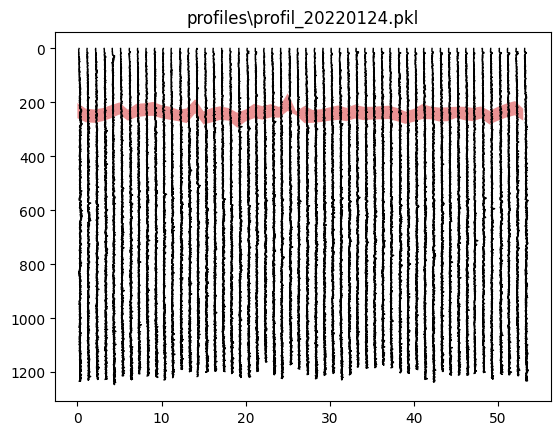

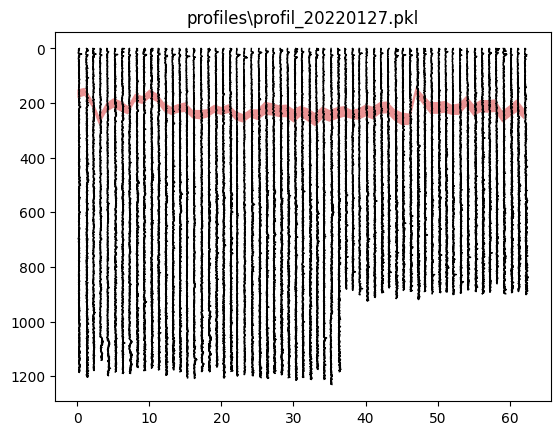

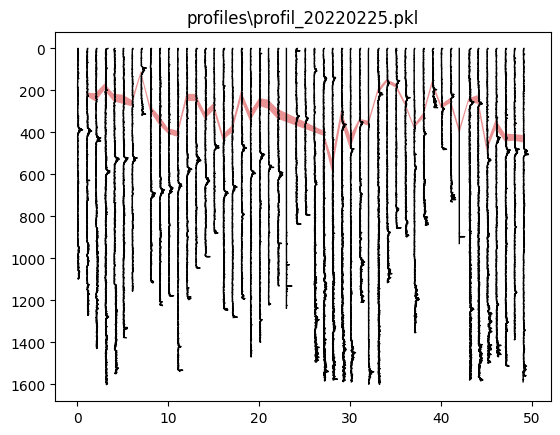

In [6]:
def plot_survey(survey, feature='force_median'):
    fig, ax = plt.subplots()

    isweak = []
    for i, (key, profile) in enumerate(survey.items()):
        plt.plot(i + 2 * np.log10(profile[feature]/profile[feature].max() + 1), profile['distance'], c='k', lw=1)
        try:
            wl = profile['distance'].loc[profile['layer'] == 'WL'].iloc[[0, -1]]
            isweak.append((i, *wl))
        
        except Exception:
            pass

    ax.fill_between(*np.array(isweak).T, fc='tab:red', alpha=0.5)
    ax.invert_yaxis()
    return fig, ax

for key, survey in surveys.items():
    fig, ax = plot_survey(survey, feature='L2012_L')
    ax.set_title(key)

Looking at multiple profiles in this manner, we learn that:
- For a given survey, the weak layer is relatively constant. Therefore, we cannot use depth solely as an indicator as it won't do a really good job at generalizing. 
- The maximum depth is varying on a profile basis - this will need to be accounted for when using a U-Net or some other DL architecture.

Let's define some helper functions that will help us manipulate our data. For now, computing a few rolling windows of the available data will help us easily generate features to work with.

In [7]:
help(ut.pickle_to_data)

Help on function pickle_to_data in module utils:

pickle_to_data(survey_dict, nwindow=100)
    Takes as input a dictionary of DataFrames containing the profile information. 
    Computes, for different window sizes, rolling statistics for the data. 
    
    Args:
        survey_dict (dict): The various profiles 
    
    Returns:
        X (DataFrame): The normalized data
        y (DataFrame or maybe Series idk): The target variable.



In [8]:
nwindows = [10, 100, 1000]
X, y = ut.pickle_to_data(profiles_flattened, nwindow=nwindows)
X = X.dropna()
y = y.loc[X.index]
X

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  ret

,force_median_mean_rolling_10,fmax_mean_rolling_10,L2012_lambda_mean_rolling_10,L2012_f0_mean_rolling_10,L2012_delta_mean_rolling_10,L2012_L_mean_rolling_10,npeaks_mean_rolling_10,B2009_psi_mean_rolling_10,gradient_psi_mean_rolling_10,delta_bellaire_mean_rolling_10,...,fmax_kurt_rolling_1000,L2012_lambda_kurt_rolling_1000,L2012_f0_kurt_rolling_1000,L2012_delta_kurt_rolling_1000,L2012_L_kurt_rolling_1000,npeaks_kurt_rolling_1000,B2009_psi_kurt_rolling_1000,gradient_psi_kurt_rolling_1000,delta_bellaire_kurt_rolling_1000,delta_bellairef5_kurt_rolling_1000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818546,0.203552,0.134688,0.630030,0.000010,0.048442,0.002572,0.731149,0.011730,0.442944,0.356,...,21.221771,65.306332,282.942813,62.533786,13.765213,41.294081,37.105230,92.065670,24.387968,-3.0
818547,0.203808,0.134945,0.604300,0.000013,0.047644,0.002873,0.709793,0.012228,0.443077,0.356,...,21.224233,62.772342,282.924468,62.551210,13.725770,39.620437,36.990352,92.293109,23.025500,-3.0
818548,0.204347,0.135249,0.609412,0.000013,0.046866,0.002802,0.714227,0.012395,0.442662,0.356,...,21.224137,59.611669,282.891738,62.561362,13.674748,37.835142,36.902459,92.295851,23.116192,-3.0
818549,0.205130,0.135773,0.591867,0.000013,0.048186,0.002987,0.700023,0.012311,0.442728,0.356,...,21.224093,56.753280,282.855966,62.547249,13.621931,36.194578,36.772444,92.501899,22.936224,-3.0


If we concatenate every profile from every survey, concatenating every data point results in a large amount of rows! Let's see what the data looks like. We will ask ourselves the following questions:

1. How is data distributed amongst the different layers? For now, we only investigate the weak layers and consider anything else to be grouped together. What % of our data is weak layers?
2. How are the profiles correlated amongst surveys? Do different profiles across different surveys show wildly different data?

To adress point #1, we can easily look at the distribution of 0s and 1s across our entire data. Around 3% of our data points are weak layers.

Text(1, 0    97.079962
dtype: float64, '794649 = 97.1 %')

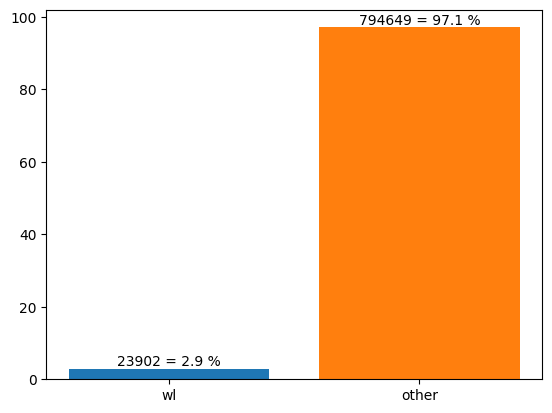

In [10]:
# the data is really imbalanced! we will need to deal with this if we use a random forest or xgboost
n_wl = y.sum()
n_other = len(y) - n_wl
ntot = len(y)

plt.bar(0, 100 * n_wl/ntot)
plt.bar(1, 100 * n_other/ntot)
plt.xticks([0, 1], ['wl', 'other'])

plt.text(0, 100 * n_wl/ntot, f'{n_wl[0]:.0f} = {100 * n_wl[0]/ntot:.1f} %', ha='center', va='bottom')
plt.text(1, 100 * n_other/ntot, f'{n_other[0]:.0f} = {100 * n_other[0]/ntot:.1f} %', ha='center', va='bottom')

Now, for point #2, we will use PCA to see how every surveys are distributed inside the entire data domain we have.

In [56]:
# there doesn't seem to be a clear, linear transformation that easily splits the data!
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
pipe.fit(X)
Z = pipe.transform(X)

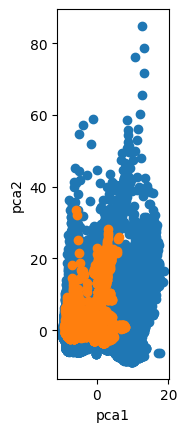

In [57]:
# plotting the entire data shows this distribution
isweak = y.astype(bool).values.reshape(-1)
plt.scatter(Z[~isweak, 0], Z[~isweak, 1])
plt.scatter(Z[isweak, 0], Z[isweak, 1])
plt.gca().set_aspect(1)
plt.xlabel('pca1')
plt.ylabel('pca2')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

profiles\profil_20190212.pkl


c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  ret

profiles\profil_20190327.pkl
profiles\profil_20200210.pkl
profiles\profil_20200229.pkl
profiles\profil_20200301.pkl
profiles\profil_20220119.pkl
profiles\profil_20220124.pkl
profiles\profil_20220127.pkl
profiles\profil_20220225.pkl


(-13.551273056193812, 89.53262546683673)

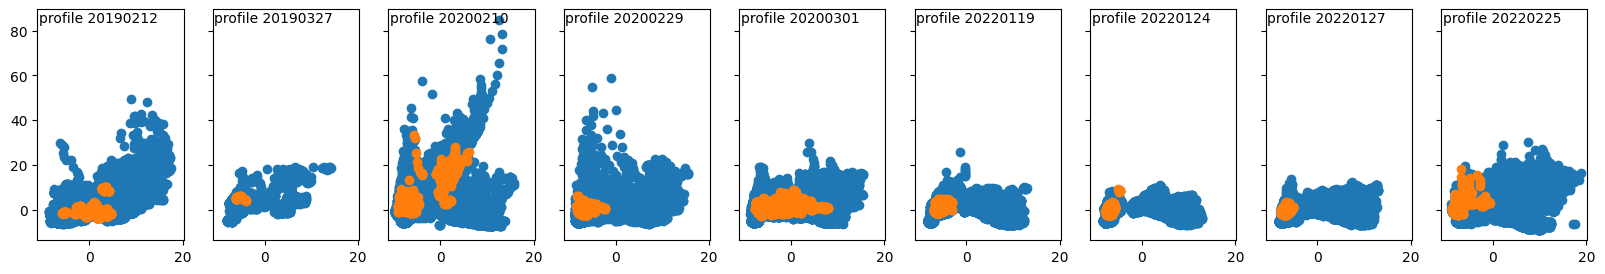

In [58]:
import os
import glob
files = glob.glob('profiles/*.pkl')

fig, axs = plt.subplots(1, len(files), sharex='all', sharey='all', figsize=(20, 3))

for i, file in enumerate(files):

    with open(file, 'rb') as f:
        print(file)
        tmp = pickle.load(f)

    subX, suby = ut.pickle_to_data(tmp, nwindow=nwindows)
    subZ = pipe.transform(subX)

    isweak = suby.astype(bool).values.reshape(-1)
    axs[i].scatter(subZ[~isweak, 0], subZ[~isweak, 1    ])
    axs[i].scatter(subZ[isweak, 0], subZ[isweak, 1])
    axs[i].text(0.01, 0.99, 'profile ' + file.split('_')[1].split('.')[0], ha='left', va='top', transform=axs[i].transAxes)

axs[-1].set_xlim(xlim)
axs[-1].set_ylim(ylim)

Surveys #4, 6, 7, 8 and 9 all seem to have very similar characteristics. Surveys 1, 2, 3, and 5 are more different. Interestingly enough, the weak layers are all overlapping the rest of the data, apart from survey #6 where there is a clear cluster (still overlapping however).

 In the next notebook, we will use the surveys #1 through #5 to create a training dataset, while keeping #6 through 9 for validation.